# Curve Fitting with an MLP
In this task, we want to fit a cosine function with a Multi-Layer Perceptron, where we minimize the Mean Square deviation between the prediction of the MLP and the true curve. The sigmoid activation provided by `edf` is bounded by 1, and therefore probably not optimally suited for curve fitting. We therefore need to implement and unbounded activation function, where we choose the rectified linear unit ReLu. We need to implement a loss that measures the Mean Square deviation, and implement the training procedure. The task is only to implement the forward and backward passes. Almost the entire rest of the code is provided. 
Tasks:
1. Implement Forward and Backward of ReLu
2. Implement Forward and Backward of MSELoss
3. Randomize the data
4. Implement the MLP
5. Run the training
6. Run the training again for two different learning rates and plot the logs. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import math

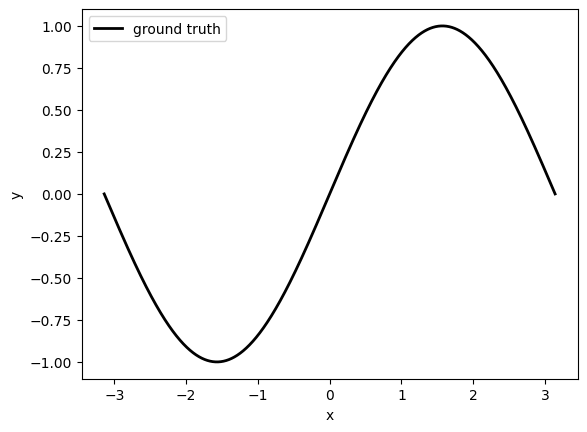

In [2]:
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

plt.plot(x,y, color="black", linewidth=2, label="ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Implementation of ReLu
First you should implement the ReLu activation function. The ReLu function can be written as 
$$\text{ReLu}\left(x\right) = \text{max}\left(0,x\right)$$ 
where max denotes the maximum function that is applied pointswise, i.e. to every element independently. 

ReLu has only one input variable $x$, so the is only one Jacobi-Matrix $J_x$. For implementing in EDF, you need to implement the action of the Jacobi Matrix $J_x$ on the vector that is stored as `self.grad`. Do the following steps. 

1. Make clear to you what are the input and output dimensions of ReLu. What is the matrix shape? How about batch size?
2. Implement the forward pass. Check the EDF code and decide how to do it.
3. Make yourself clear (with pen and paper), what is the Jacobi matrix $J_x$ for a vector $x$. For example if x=(-1, -0.5, 0., 0.5, 1)
4. What is the shape of `self.grad` - the gradient propagated into the ReLu class from somewhere else in the graph?
5. Make yourself clear with pen and paper, how the Jacobi Matrix should act on `self.grad`
6. Implement the propagation of the gradient into the input of ReLu.

In [3]:
class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # implementation goes here

    def backward(self):
        # implementation goes here

IndentationError: expected an indented block after function definition on line 6 (2088737274.py, line 9)

Check your implementation with this code block. It does the following. It creates a Parameter, i.e. a variable that can have a gradient with values from -2 to 2. Apply the ReLu function to the parameter. The call `edf.Forward` and `edf.Backward`, where the output of the ReLu is used as argument to `Backward`. During the backward pass, the gradient of the output is initialized with a vector of ones (for batch size 1), and the Jacobi Matrix acts on this vector of ones. Hence, we can check if our implementation works as expected. 

What does this expression do? `values[None, :]`

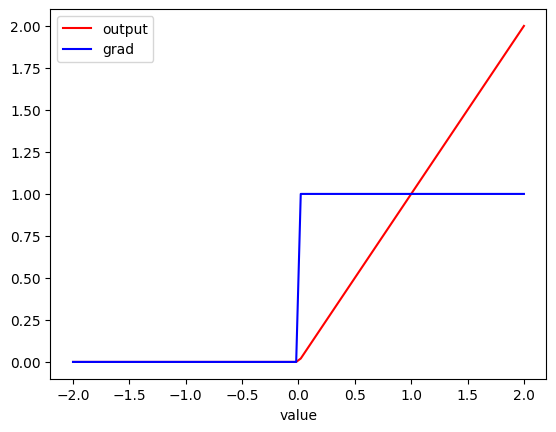

In [4]:
values = np.linspace(-2,2,100)
edf.clear_compgraph()
param = edf.Parameter(values[None, :])
output = ReLU(param)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, param.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()

# Implementation of a mean square error loss
Now we implement a loss given by the mean square error
$$
\text{MSE}\left( x, y \right) = \sum_{i} \left( x_i - y_i \right)^2 
$$.
For the backward pass, we have two Jacobi Matrices $J_x$ and $J_y$. Now you need to implement the forward pass, of course, and the action of both Jacobians on the grad of the MSE. Perform the same steps:
1. Make yourself clear about input and output dimension. Note that the Loss is not summed over the mini-batch, but per sample.
2. Implement the forward pass, for example with `numpy.linalg.norm`, or `numpy.sum`. You will need to pass an `axis` argument.
3. Write down the Jacobi Matrices with pen and paper.
4. Implement the backward pass that propagates the gradient into the inputs of the MSELoss.

In my implementation, I had to be careful that I would do a pointwise product of self.grad with the term that comes from the derivative of $(x-y)^2$. 

In [146]:
class MSELoss():
    def __init__(self, x, y, *args, **kwargs):
        edf.CompNodes.append(self)
        self.x = x
        self.y = y        
        
    def forward(self):
        print("x shape:", self.x.value.shape) # debug output, remove later.
        print("y shape:", self.y.value.shape) # debug output, remove later.
        

    def backward(self):
        print("self.grad.shape", self.grad.shape)


Now we want to check the backward pass. We assume x to be linearly spaced between -2 and 2, and y to be constant at 1, batch size 1. We define two parameters and run `Forward` and `Backward`. Now we obtain a loss of shape (batch_size, ), so a scalar. The gradients of this loss with respect to the entries of vector $x$ and $y$ we can check.  

In [147]:
xvalues = np.linspace(-2,2,100)
yvalues = np.ones_like(xvalues)

edf.clear_compgraph()
xparam = edf.Parameter(xvalues[None, :])
yparam = edf.Parameter(yvalues[None, :])
output = MSELoss(xparam, yparam)

edf.Forward()
edf.Backward(output)

print("Shape of x", xparam.value.shape)
print("Shape of y", yparam.value.shape)
print("Shape of MSELoss", output.value.shape)

plt.xlabel("value")
#plt.plot(xvalues, output.value[0], color='red')
plt.plot(xvalues, xparam.grad[0], color='blue', label="x gradient")
plt.plot(xvalues, yparam.grad[0], color='blue', label="y gradient")
plt.legend()
plt.show()

x shape: (1, 100)
y shape: (1, 100)


AttributeError: 'MSELoss' object has no attribute 'value'

Now we want to do the actual fitting. We use 2048 points that we randomly split into train and test data. The implementation here does not shuffle the data. Add the shuffling from the previous task.

In [110]:
num_points=2048
data = np.linspace(-math.pi, math.pi, num_points)[:,None]
labels = np.sin(data)

#Copy the randomization block here. 

# Now split the data into Train and Test with a fraction of 20%
test_fraction=0.25
number_train_samples=int( (1-test_fraction)*num_points )
# In order to make your life as simple as possible, we can just use the sample variable names
# for train and test imags and labels as in the MNist Example
train_data=data[:number_train_samples]
train_labels=labels[:number_train_samples]
test_data=data[number_train_samples:]
test_labels=labels[number_train_samples:]

Now it is time to build the MLP. It should be implemented as Affine_Last( ReLu ( Affine_First (x) ) ). Implement this. You can either implement a function for this, as in previous examples, or just instantiate two instances of edf.Affine and one instance of ReLu. Define a variable for the output of the model. What do you have to assign here?
Now define the loss based on your previous implementation of the MSELoss. 

In [128]:
nInputs = 1
nLabels = 1

class MLPparams(edf.ParameterPackage):
    def __init__(self,nInputs, nHiddens, nLabels):
        self.first = edf.AffineParams(nInputs,nHiddens)
        self.last = edf.AffineParams(nHiddens,nLabels)

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)


output = # 
lossnode = #

We changed the training code from previous examples only minimally. Can you spot where the difference is?

In [1]:
def run_epoch(batch_size, data, labels, xnode, ynode, probnode, lossnode=None):
    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples//batch_size
    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size
        xnode.value = train_data[start:end]
        ynode.value = train_labels[start:end]
        edf.Forward()
        total_err += np.sum( (probnode.value-ynode.value)**2 ) 
        if lossnode:
            edf.Backward(lossnode)
            edf.SGD()
        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))
    return total_err/num_samples

def train(num_epochs, batch_size, xnode, ynode, probnode, lossnode):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        train_err = run_epoch(batch_size, train_data, train_labels, xnode, ynode, probnode, lossnode)
        train_err_log.append(train_err)
        print ("\t Training Error {:.4f}".format(train_err))
        test_err = run_epoch(len(test_data), test_data, test_labels, xnode, ynode, probnode)
        test_err_log.append(test_err)
        print ("\t Test Error {:.4f}".format(test_err))
    return train_err_log, test_err_log

Now we can run the training and plot the log. 

In [133]:
num_epochs = 1000
batch_size = 128
edf.learning_rate = 0.01
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, output, lossnode)

Epoch: 1/1000
	 Training Error 0.0644
	 Test Error 0.0633
Epoch: 2/1000
	 Training Error 0.0640
	 Test Error 0.0629
Epoch: 3/1000
	 Training Error 0.0636
	 Test Error 0.0625
Epoch: 4/1000
	 Training Error 0.0632
	 Test Error 0.0621
Epoch: 5/1000
	 Training Error 0.0628
	 Test Error 0.0617
Epoch: 6/1000
	 Training Error 0.0624
	 Test Error 0.0613
Epoch: 7/1000
	 Training Error 0.0620
	 Test Error 0.0609
Epoch: 8/1000
	 Training Error 0.0616
	 Test Error 0.0606
Epoch: 9/1000
	 Training Error 0.0612
	 Test Error 0.0602
Epoch: 10/1000
	 Training Error 0.0608
	 Test Error 0.0598
Epoch: 11/1000
	 Training Error 0.0605
	 Test Error 0.0595
Epoch: 12/1000
	 Training Error 0.0601
	 Test Error 0.0591
Epoch: 13/1000
	 Training Error 0.0597
	 Test Error 0.0588
Epoch: 14/1000
	 Training Error 0.0594
	 Test Error 0.0584
Epoch: 15/1000
	 Training Error 0.0590
	 Test Error 0.0581
Epoch: 16/1000
	 Training Error 0.0586
	 Test Error 0.0577
Epoch: 17/1000
	 Training Error 0.0583
	 Test Error 0.0574
Epoch:

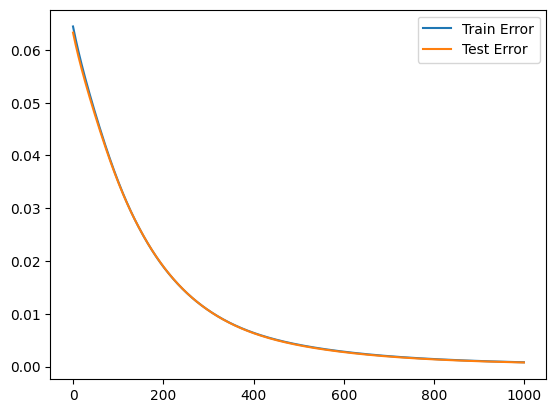

In [139]:
plt.plot(train_err_log, label="Train Error")
plt.plot(test_err_log, label="Test Error")
plt.legend()

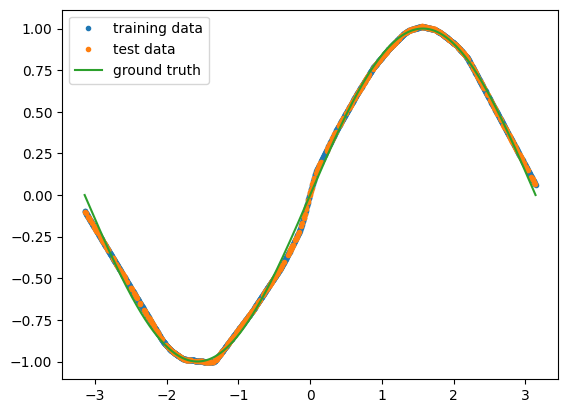

In [140]:
xnode.value = train_data
ynode.value = train_labels
edf.Forward()
plt.plot(xnode.value, output.value, ".", label="training data")
xnode.value = test_data
ynode.value = test_labels
edf.Forward()
plt.plot(xnode.value, output.value, ".", label="test data")


plt.plot(x,y, label="ground truth")
plt.legend()

Run the training again with two different learning rates and plot the results. 

In [ ]:
#code goes here.